<a href="https://colab.research.google.com/github/dipayandas97/Reservoir_Computing/blob/master/Project%20I/DQN_torch_LSM_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/My Drive/ISI/LSM_RL/Project I/')

import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
from collections import deque
import torch
import time

from torch_LSM_v1 import torch_LSM, get_readout_network
from spike_encoding import spike_encoding

import gym

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


##Agent

In [ ]:
class Agent:
    def __init__(self, state_space_size, state_space_bounds, action_space_size, reservoir_size, lsm_K=4, lsm_C=4):
        self.state_space_size = state_space_size
        self.action_space_size = action_space_size

        self.memory = deque(maxlen=100000)
        self.epsilon = 1
        self.epsilon_min = 0.05
        self.gamma = 0.95
        self.batch_size = 32
        self.training_threshold = 100
        self.Tau = 0.5
        
        self.lsm = torch_LSM(input_size=state_space_size, 
                             output_size=action_space_size, 
                             width=reservoir_size[0], height=reservoir_size[1], depth=reservoir_size[2], 
                             C = lsm_C, K = lsm_K)
        self.lsm.reset_state()

        self.target_network = get_readout_network(input_size=self.lsm.num_of_excitatory_neurons, 
                                                  hidden_size=self.lsm.num_of_excitatory_neurons,
                                                  output_size=self.lsm.output_size)
        self.target_network = self.target_network.to(device)

        self.state_space_bounds = state_space_bounds
        self.spike_encoder = spike_encoding(scheme='poisson_rate_coding', time_window=300, input_range=(0,10), output_freq_range=(1,100))
        #self.spike_encoders = []
        #for i in range(state_space_size):
        #    self.spike_encoders.append(spike_encoding(scheme='poisson_rate_coding', time_window=300, input_range=state_space_bounds[i], output_freq_range=(1,100)))

        self.spike_amplitude_scaling_constant = 100
        
    def discretize_state_value(self, value, bounds):
        value = bounds[1] if value>bounds[1] else bounds[1]    #Clipping
        value = bounds[0] if value<bounds[0] else bounds[0]   #Clipping
        value += abs(bounds[0]) #Mean shift to : [0, max_value]
        interval = (bounds[1] - bounds[0]) / 10   #10 discrete levels
        for i in range(10):
            if (value >= i*interval) and (value <= (i+1)*interval):
                #print(i, interval, value)
                return i                          #Return label encoded state value

    def get_spike_data(self, input_state):        
        #Convert to spikes
        spike_train = []
        for idx, s in enumerate(input_state): 
            discrete_state_value = self.discretize_state_value(value=s, bounds=self.state_space_bounds[idx])
            spike_train.append(self.spike_encoder.encode(np.asarray([[discrete_state_value]]))[0])    #Use a single encoder with input range [0,10]
        spike_train = np.asarray(spike_train) * self.spike_amplitude_scaling_constant
        return spike_train

    def get_readout_values(self, input_state, output='q_values', network='q_network'):
        if len(input_state.shape) == 2: #Batch input
            #Convert input states to batched spike trains
            batch_spike_data = []
            for state in input_state:                   
                batch_spike_data.append(self.get_spike_data(state))
            #For Q network:
            if network=='q_network':
                if output=='q_values':
                    #Obtain Q values in batch
                    batch_q_values = self.lsm.predict_on_batch(np.asarray(batch_spike_data), output=output)
                    return batch_q_values.detach().numpy()

                elif output=='average_firing_rate_and_q_values':
                    #Obtain Q values in batch
                    batch_average_firing_rates, batch_q_values = self.lsm.predict_on_batch(np.asarray(batch_spike_data), output=output)
                    return batch_average_firing_rates.detach().cpu().numpy(), batch_q_values.detach().cpu().numpy()
            #For target network
            elif network=='target_network' and output=='q_values':
                #Obtain LSM processed data
                batch_average_firing_rates = self.lsm.predict_on_batch(np.asarray(batch_spike_data), output='average_firing_rate')
                #plt.plot(batch_average_firing_rates[0])
                #plt.show()
                batch_target_q_values = self.target_network(batch_average_firing_rates)
                return batch_target_q_values.detach().cpu().numpy()

        else: #Single input
            #Convert input states to spike trains
            spike_train = self.get_spike_data(input_state)           
            #Pass it through LSM
            q_values = self.lsm.predict(spike_train)            
            return q_values.detach().cpu().numpy()

    def get_action(self, input_state, epsilon = None):
        epsilon = self.epsilon if epsilon==None else epsilon

        if random.uniform(0,1) < epsilon:
            return np.random.randint(0, self.action_space_size, 1)[0]
        else:
            return np.argmax(self.get_readout_values(input_state)) 

    def update_epsilon(self, diff, episode=None):
        if len(self.memory) > self.training_threshold:
            if self.epsilon > self.epsilon_min:
                self.epsilon -= diff

    def update_target_network(self):
        for layer in self.target_network.state_dict():
            self.target_network.state_dict()[layer] = (1-self.Tau)*self.target_network.state_dict()[layer] + self.Tau*self.lsm.readout_network.state_dict()[layer]

    def remember(self, info):
        self.memory.append(info)

    def replay(self):
        if len(self.memory) > self.training_threshold:
            
            #1. Randomly sample a mini_batch
            minibatch = random.sample(self.memory, self.batch_size)

            #2. Segregate the data 
            state = np.zeros((self.batch_size, self.state_space_size))
            next_state = np.zeros((self.batch_size, self.state_space_size))
            action, reward, dead = [], [], []

            for i in range(self.batch_size):
                state[i] = minibatch[i][0]
                action.append(minibatch[i][1])
                reward.append(minibatch[i][2])
                next_state[i] = minibatch[i][3]
                dead.append(minibatch[i][4])

            #3. Prepare inputs and targets for readout layer
            lsm_states, target = self.get_readout_values(state, output='average_firing_rate_and_q_values')
            #Clipping : Min(q_values of target and q network for next state)
            next_state_q_value_ = self.get_readout_values(next_state, output='q_values', network='q_network')
            next_state_q_value = self.get_readout_values(next_state, output='q_values', network='target_network')

            for i in range(self.batch_size):
                next_best_q = min(np.max(next_state_q_value_[i]),np.max(next_state_q_value[i]))
                target[i][action[i]] = reward[i] + (not dead[i])*self.gamma*(next_best_q)

            #4. Update the readout network
            inputs, targets = torch.from_numpy(lsm_states).to(device), torch.from_numpy(target).to(device)
            return self.lsm.train_readout_network(inputs=inputs, targets=targets)

    def save_lsm(self, path=''): 
        #lsm_parameters = [ self.lsm.input_weight_matrix, self.lsm.liquid_weight_matrix, self.lsm.readout_network.get_weights()]
        
        #f = open(path+'best_lsm_model_parameters.pkl', 'wb')
        #pickle.dump(lsm_parameters, f)
        #f.close()
        pass

    def load_lsm(self, path): #[ input weight matrix, liq layer weight matrix, readout weights]
        #f = open(path, 'rb')
        #parameters_list = pickle.load(f)
        #f.close()
        pass

        #self.lsm.input_weight_matrix = parameters_list[0]
        #self.lsm.liquid_weight_matrix = parameters_list[1]
        #self.lsm.readout_network.set_weights(parameters_list[2])        
        pass

    def save_lsm_state(self):
        #N_t, V_m, R_c = self.lsm.liquid_layer_neurons.N_t,self.lsm.liquid_layer_neurons.V_m,self.lsm.liquid_layer_neurons.R_c
        #self.last_lsm_state = [N_t, V_m, R_c] 
        pass

    def resume_lsm_state(self):
        #self.lsm.liquid_layer_neurons.N_t,self.lsm.liquid_layer_neurons.V_m,self.lsm.liquid_layer_neurons.R_c = self.last_lsm_state[0], self.last_lsm_state[1], self.last_lsm_state[2]
        pass

##Main

In [ ]:
EPISODES = 100000

env = gym.make('CartPole-v0')

#state_space_bounds = [(-2.4,2.4), (-255,255), (-41.8, 41.8), (-255,255)]
state_space_bounds = [(-2.4,2.4), (-0.5,0.5), (-0.28, 0.28), (-0.88, 0.88)]

agent = Agent(state_space_size=env.observation_space.shape[0], 
            state_space_bounds=state_space_bounds, 
            action_space_size=env.action_space.n, 
            reservoir_size=(6,6,6),
            lsm_C = 2)

Total_timesteps: 0.0 | Epsilon: 1


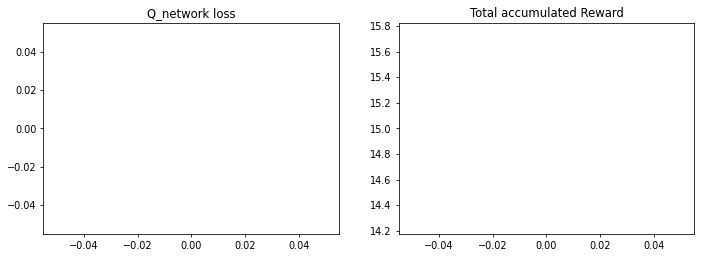

.......................................................................................................
Evaluation Score:  9.78640776699029
Total_timesteps: 15 | Epsilon: 1
Total_timesteps: 29 | Epsilon: 1
Total_timesteps: 47 | Epsilon: 1
Total_timesteps: 59 | Epsilon: 1
Total_timesteps: 96 | Epsilon: 1
Total_timesteps: 113 | Epsilon: 1
Total_timesteps: 135 | Epsilon: 1
Total_timesteps: 155 | Epsilon: 1
Total_timesteps: 177 | Epsilon: 1
Total_timesteps: 197 | Epsilon: 1
Total_timesteps: 217 | Epsilon: 1
Total_timesteps: 252 | Epsilon: 1
Total_timesteps: 295 | Epsilon: 1
Total_timesteps: 305 | Epsilon: 1
Total_timesteps: 322 | Epsilon: 1
Total_timesteps: 336 | Epsilon: 1
Total_timesteps: 350 | Epsilon: 1
Total_timesteps: 402 | Epsilon: 1


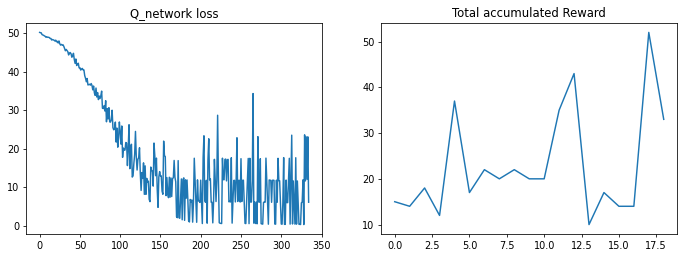

........................................................................................................
Evaluation Score:  9.634615384615385
Total_timesteps: 435 | Epsilon: 0.996
Total_timesteps: 461 | Epsilon: 0.996
Total_timesteps: 474 | Epsilon: 0.996
Total_timesteps: 489 | Epsilon: 0.996
Total_timesteps: 518 | Epsilon: 0.996
Total_timesteps: 536 | Epsilon: 0.996
Total_timesteps: 559 | Epsilon: 0.996
Total_timesteps: 589 | Epsilon: 0.996
Total_timesteps: 599 | Epsilon: 0.996
Total_timesteps: 634 | Epsilon: 0.996
Total_timesteps: 661 | Epsilon: 0.996
Total_timesteps: 671 | Epsilon: 0.996
Total_timesteps: 682 | Epsilon: 0.996
Total_timesteps: 692 | Epsilon: 0.996
Total_timesteps: 713 | Epsilon: 0.996
Total_timesteps: 739 | Epsilon: 0.996
Total_timesteps: 798 | Epsilon: 0.996
Total_timesteps: 812 | Epsilon: 0.996


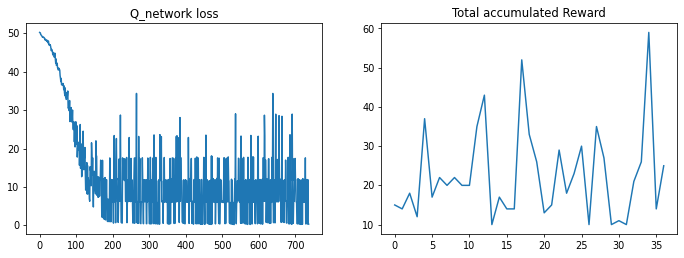

.........................................................................................................
Evaluation Score:  9.533333333333333
Total_timesteps: 837 | Epsilon: 0.992
Total_timesteps: 847 | Epsilon: 0.992
Total_timesteps: 892 | Epsilon: 0.992
Total_timesteps: 906 | Epsilon: 0.992
Total_timesteps: 938 | Epsilon: 0.992
Total_timesteps: 947 | Epsilon: 0.992
Total_timesteps: 965 | Epsilon: 0.992
Total_timesteps: 1004 | Epsilon: 0.992
Total_timesteps: 1037 | Epsilon: 0.992
Total_timesteps: 1050 | Epsilon: 0.992
Total_timesteps: 1062 | Epsilon: 0.992
Total_timesteps: 1075 | Epsilon: 0.992
Total_timesteps: 1086 | Epsilon: 0.992
Total_timesteps: 1123 | Epsilon: 0.992
Total_timesteps: 1138 | Epsilon: 0.992
Total_timesteps: 1169 | Epsilon: 0.992
Total_timesteps: 1204 | Epsilon: 0.992


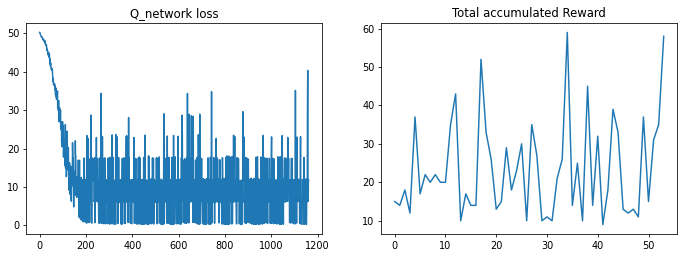

......................................................................................................
Evaluation Score:  9.833333333333334
Total_timesteps: 1262 | Epsilon: 0.988
Total_timesteps: 1295 | Epsilon: 0.988
Total_timesteps: 1320 | Epsilon: 0.988
Total_timesteps: 1336 | Epsilon: 0.988
Total_timesteps: 1362 | Epsilon: 0.988
Total_timesteps: 1377 | Epsilon: 0.988
Total_timesteps: 1387 | Epsilon: 0.988
Total_timesteps: 1400 | Epsilon: 0.988
Total_timesteps: 1422 | Epsilon: 0.988
Total_timesteps: 1451 | Epsilon: 0.988
Total_timesteps: 1464 | Epsilon: 0.988
Total_timesteps: 1503 | Epsilon: 0.988
Total_timesteps: 1537 | Epsilon: 0.988
Total_timesteps: 1568 | Epsilon: 0.988
Total_timesteps: 1583 | Epsilon: 0.988
Total_timesteps: 1622 | Epsilon: 0.988
Total_timesteps: 1632 | Epsilon: 0.988
Total_timesteps: 1659 | Epsilon: 0.988


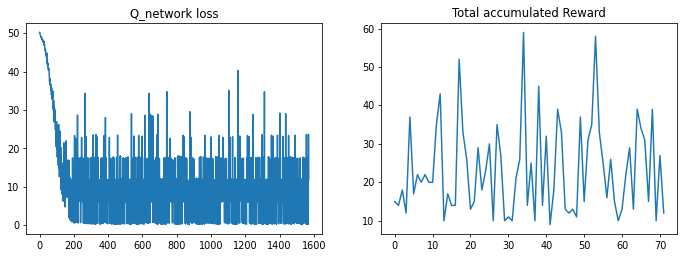

.........................................................................................................
Evaluation Score:  9.571428571428571
Total_timesteps: 1671 | Epsilon: 0.984
Total_timesteps: 1699 | Epsilon: 0.984
Total_timesteps: 1717 | Epsilon: 0.984
Total_timesteps: 1732 | Epsilon: 0.984
Total_timesteps: 1746 | Epsilon: 0.984
Total_timesteps: 1784 | Epsilon: 0.984
Total_timesteps: 1796 | Epsilon: 0.984
Total_timesteps: 1813 | Epsilon: 0.984
Total_timesteps: 1824 | Epsilon: 0.984
Total_timesteps: 1843 | Epsilon: 0.984
Total_timesteps: 1923 | Epsilon: 0.984
Total_timesteps: 1961 | Epsilon: 0.984
Total_timesteps: 1971 | Epsilon: 0.984
Total_timesteps: 1987 | Epsilon: 0.984
Total_timesteps: 2015 | Epsilon: 0.984


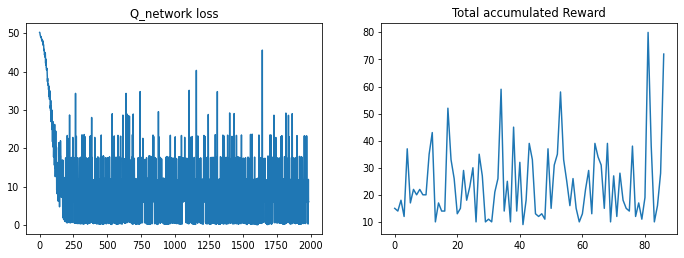

.........................................................................................................
Evaluation Score:  9.552380952380952
Total_timesteps: 2087 | Epsilon: 0.98
Total_timesteps: 2099 | Epsilon: 0.98
Total_timesteps: 2112 | Epsilon: 0.98
Total_timesteps: 2133 | Epsilon: 0.98
Total_timesteps: 2166 | Epsilon: 0.98
Total_timesteps: 2187 | Epsilon: 0.98
Total_timesteps: 2200 | Epsilon: 0.98
Total_timesteps: 2241 | Epsilon: 0.98
Total_timesteps: 2258 | Epsilon: 0.98
Total_timesteps: 2285 | Epsilon: 0.98
Total_timesteps: 2325 | Epsilon: 0.98
Total_timesteps: 2340 | Epsilon: 0.98
Total_timesteps: 2352 | Epsilon: 0.98
Total_timesteps: 2376 | Epsilon: 0.98
Total_timesteps: 2408 | Epsilon: 0.98
Total_timesteps: 2425 | Epsilon: 0.98
Total_timesteps: 2448 | Epsilon: 0.98
Total_timesteps: 2462 | Epsilon: 0.98


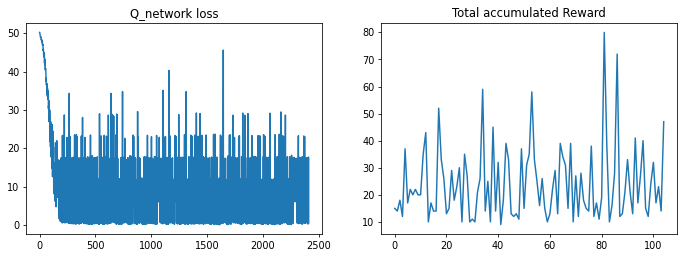

.........................................................................................................
Evaluation Score:  9.561904761904762
Total_timesteps: 2509 | Epsilon: 0.976
Total_timesteps: 2518 | Epsilon: 0.976
Total_timesteps: 2542 | Epsilon: 0.976
Total_timesteps: 2570 | Epsilon: 0.976
Total_timesteps: 2583 | Epsilon: 0.976
Total_timesteps: 2597 | Epsilon: 0.976
Total_timesteps: 2650 | Epsilon: 0.976
Total_timesteps: 2664 | Epsilon: 0.976
Total_timesteps: 2680 | Epsilon: 0.976
Total_timesteps: 2692 | Epsilon: 0.976
Total_timesteps: 2713 | Epsilon: 0.976
Total_timesteps: 2745 | Epsilon: 0.976
Total_timesteps: 2758 | Epsilon: 0.976
Total_timesteps: 2770 | Epsilon: 0.976
Total_timesteps: 2802 | Epsilon: 0.976
Total_timesteps: 2891 | Epsilon: 0.976


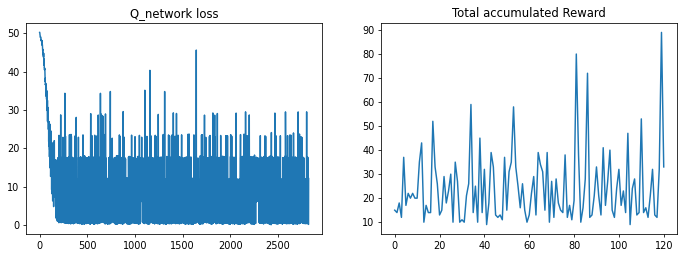

..........................................................................................................
Evaluation Score:  9.50943396226415
Total_timesteps: 2924 | Epsilon: 0.972
Total_timesteps: 2966 | Epsilon: 0.972
Total_timesteps: 2980 | Epsilon: 0.972
Total_timesteps: 2993 | Epsilon: 0.972
Total_timesteps: 3015 | Epsilon: 0.972
Total_timesteps: 3031 | Epsilon: 0.972
Total_timesteps: 3047 | Epsilon: 0.972
Total_timesteps: 3063 | Epsilon: 0.972
Total_timesteps: 3079 | Epsilon: 0.972
Total_timesteps: 3095 | Epsilon: 0.972
Total_timesteps: 3109 | Epsilon: 0.972
Total_timesteps: 3140 | Epsilon: 0.972
Total_timesteps: 3167 | Epsilon: 0.972
Total_timesteps: 3193 | Epsilon: 0.972
Total_timesteps: 3217 | Epsilon: 0.972
Total_timesteps: 3274 | Epsilon: 0.972
Total_timesteps: 3301 | Epsilon: 0.972
Total_timesteps: 3314 | Epsilon: 0.972


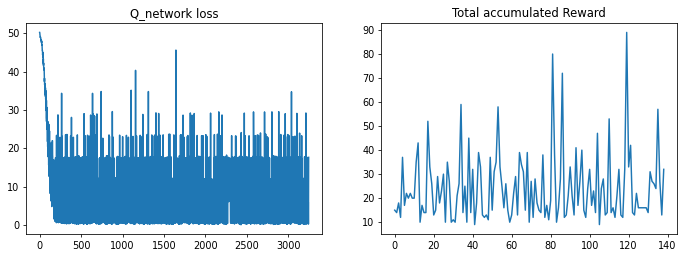

........................................................................................................
Evaluation Score:  9.615384615384615
Total_timesteps: 3346 | Epsilon: 0.968
Total_timesteps: 3361 | Epsilon: 0.968
Total_timesteps: 3380 | Epsilon: 0.968
Total_timesteps: 3394 | Epsilon: 0.968
Total_timesteps: 3412 | Epsilon: 0.968
Total_timesteps: 3460 | Epsilon: 0.968
Total_timesteps: 3481 | Epsilon: 0.968
Total_timesteps: 3537 | Epsilon: 0.968
Total_timesteps: 3561 | Epsilon: 0.968
Total_timesteps: 3603 | Epsilon: 0.968
Total_timesteps: 3636 | Epsilon: 0.968
Total_timesteps: 3652 | Epsilon: 0.968
Total_timesteps: 3671 | Epsilon: 0.968
Total_timesteps: 3683 | Epsilon: 0.968
Total_timesteps: 3693 | Epsilon: 0.968
Total_timesteps: 3706 | Epsilon: 0.968
Total_timesteps: 3722 | Epsilon: 0.968
Total_timesteps: 3740 | Epsilon: 0.968


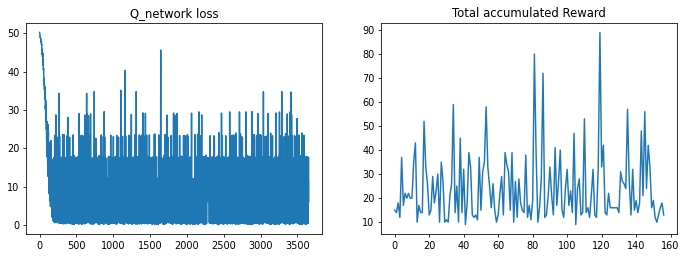

.........................................................................................................
Evaluation Score:  9.6
Total_timesteps: 3753 | Epsilon: 0.964
Total_timesteps: 3765 | Epsilon: 0.964
Total_timesteps: 3805 | Epsilon: 0.964
Total_timesteps: 3822 | Epsilon: 0.964
Total_timesteps: 3834 | Epsilon: 0.964
Total_timesteps: 3865 | Epsilon: 0.964
Total_timesteps: 3898 | Epsilon: 0.964
Total_timesteps: 3915 | Epsilon: 0.964
Total_timesteps: 3926 | Epsilon: 0.964
Total_timesteps: 3941 | Epsilon: 0.964
Total_timesteps: 3957 | Epsilon: 0.964
Total_timesteps: 3969 | Epsilon: 0.964
Total_timesteps: 3978 | Epsilon: 0.964
Total_timesteps: 4009 | Epsilon: 0.964
Total_timesteps: 4023 | Epsilon: 0.964
Total_timesteps: 4036 | Epsilon: 0.964
Total_timesteps: 4056 | Epsilon: 0.964
Total_timesteps: 4067 | Epsilon: 0.964
Total_timesteps: 4080 | Epsilon: 0.964
Total_timesteps: 4108 | Epsilon: 0.964
Total_timesteps: 4123 | Epsilon: 0.964


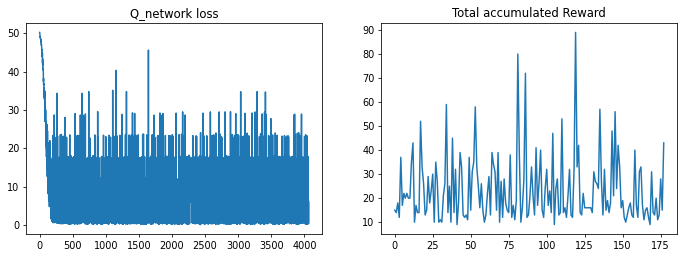

.........................................................................................................
Evaluation Score:  9.552380952380952
Total_timesteps: 4166 | Epsilon: 0.96
Total_timesteps: 4197 | Epsilon: 0.96
Total_timesteps: 4217 | Epsilon: 0.96
Total_timesteps: 4241 | Epsilon: 0.96
Total_timesteps: 4254 | Epsilon: 0.96
Total_timesteps: 4279 | Epsilon: 0.96
Total_timesteps: 4300 | Epsilon: 0.96
Total_timesteps: 4328 | Epsilon: 0.96
Total_timesteps: 4338 | Epsilon: 0.96
Total_timesteps: 4362 | Epsilon: 0.96
Total_timesteps: 4389 | Epsilon: 0.96
Total_timesteps: 4404 | Epsilon: 0.96
Total_timesteps: 4433 | Epsilon: 0.96
Total_timesteps: 4466 | Epsilon: 0.96
Total_timesteps: 4491 | Epsilon: 0.96
Total_timesteps: 4531 | Epsilon: 0.96
Total_timesteps: 4551 | Epsilon: 0.96


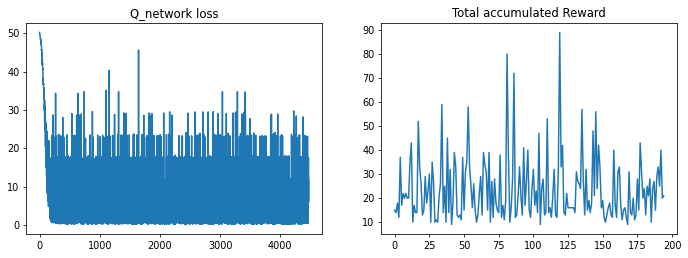

..........................................................................................................
Evaluation Score:  9.5
Total_timesteps: 4572 | Epsilon: 0.956
Total_timesteps: 4582 | Epsilon: 0.956
Total_timesteps: 4606 | Epsilon: 0.956
Total_timesteps: 4616 | Epsilon: 0.956
Total_timesteps: 4626 | Epsilon: 0.956
Total_timesteps: 4645 | Epsilon: 0.956
Total_timesteps: 4685 | Epsilon: 0.956
Total_timesteps: 4699 | Epsilon: 0.956
Total_timesteps: 4738 | Epsilon: 0.956
Total_timesteps: 4774 | Epsilon: 0.956
Total_timesteps: 4802 | Epsilon: 0.956
Total_timesteps: 4825 | Epsilon: 0.956
Total_timesteps: 4839 | Epsilon: 0.956
Total_timesteps: 4871 | Epsilon: 0.956
Total_timesteps: 4888 | Epsilon: 0.956
Total_timesteps: 4916 | Epsilon: 0.956
Total_timesteps: 4935 | Epsilon: 0.956
Total_timesteps: 4952 | Epsilon: 0.956
Total_timesteps: 4965 | Epsilon: 0.956


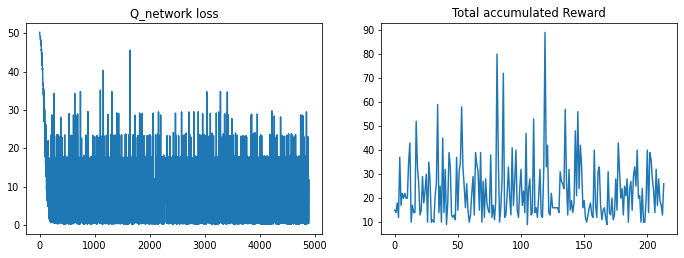

.........................................................................................................
Evaluation Score:  9.552380952380952
Total_timesteps: 4991 | Epsilon: 0.952
Total_timesteps: 5009 | Epsilon: 0.952
Total_timesteps: 5024 | Epsilon: 0.952
Total_timesteps: 5040 | Epsilon: 0.952
Total_timesteps: 5059 | Epsilon: 0.952
Total_timesteps: 5070 | Epsilon: 0.952
Total_timesteps: 5162 | Epsilon: 0.952
Total_timesteps: 5176 | Epsilon: 0.952
Total_timesteps: 5192 | Epsilon: 0.952
Total_timesteps: 5215 | Epsilon: 0.952
Total_timesteps: 5228 | Epsilon: 0.952
Total_timesteps: 5244 | Epsilon: 0.952
Total_timesteps: 5262 | Epsilon: 0.952
Total_timesteps: 5278 | Epsilon: 0.952
Total_timesteps: 5311 | Epsilon: 0.952
Total_timesteps: 5327 | Epsilon: 0.952
Total_timesteps: 5336 | Epsilon: 0.952
Total_timesteps: 5349 | Epsilon: 0.952
Total_timesteps: 5374 | Epsilon: 0.952


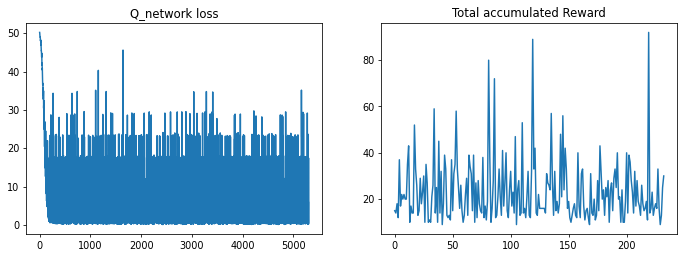

.......................................................................................................
Evaluation Score:  9.728155339805825
Total_timesteps: 5404 | Epsilon: 0.948
Total_timesteps: 5426 | Epsilon: 0.948
Total_timesteps: 5435 | Epsilon: 0.948
Total_timesteps: 5461 | Epsilon: 0.948
Total_timesteps: 5482 | Epsilon: 0.948
Total_timesteps: 5520 | Epsilon: 0.948
Total_timesteps: 5534 | Epsilon: 0.948
Total_timesteps: 5546 | Epsilon: 0.948
Total_timesteps: 5558 | Epsilon: 0.948
Total_timesteps: 5574 | Epsilon: 0.948
Total_timesteps: 5585 | Epsilon: 0.948
Total_timesteps: 5595 | Epsilon: 0.948
Total_timesteps: 5605 | Epsilon: 0.948
Total_timesteps: 5616 | Epsilon: 0.948
Total_timesteps: 5628 | Epsilon: 0.948
Total_timesteps: 5656 | Epsilon: 0.948
Total_timesteps: 5699 | Epsilon: 0.948
Total_timesteps: 5741 | Epsilon: 0.948
Total_timesteps: 5753 | Epsilon: 0.948
Total_timesteps: 5765 | Epsilon: 0.948
Total_timesteps: 5779 | Epsilon: 0.948
Total_timesteps: 5792 | Epsilon: 0.948
T

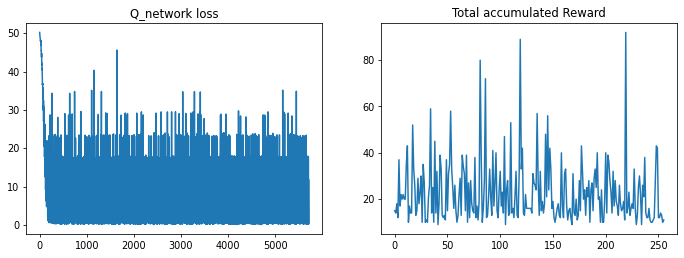

.......................................................................................................
Evaluation Score:  9.718446601941748
Total_timesteps: 5813 | Epsilon: 0.944
Total_timesteps: 5835 | Epsilon: 0.944
Total_timesteps: 5852 | Epsilon: 0.944
Total_timesteps: 5890 | Epsilon: 0.944
Total_timesteps: 5901 | Epsilon: 0.944
Total_timesteps: 5920 | Epsilon: 0.944
Total_timesteps: 5937 | Epsilon: 0.944
Total_timesteps: 5958 | Epsilon: 0.944
Total_timesteps: 5972 | Epsilon: 0.944
Total_timesteps: 5984 | Epsilon: 0.944
Total_timesteps: 6000 | Epsilon: 0.944
Total_timesteps: 6026 | Epsilon: 0.944
Total_timesteps: 6052 | Epsilon: 0.944
Total_timesteps: 6088 | Epsilon: 0.944
Total_timesteps: 6100 | Epsilon: 0.944
Total_timesteps: 6116 | Epsilon: 0.944
Total_timesteps: 6140 | Epsilon: 0.944
Total_timesteps: 6153 | Epsilon: 0.944
Total_timesteps: 6175 | Epsilon: 0.944
Total_timesteps: 6187 | Epsilon: 0.944
Total_timesteps: 6212 | Epsilon: 0.944


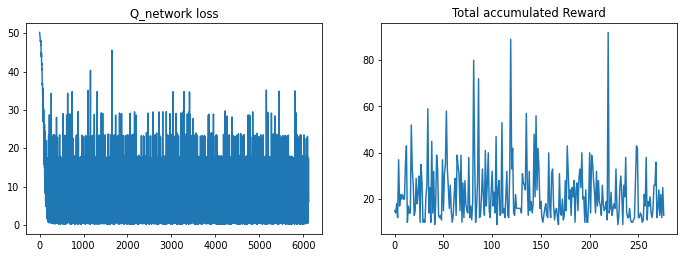

.......................................................................................................
Evaluation Score:  9.70873786407767
Total_timesteps: 6225 | Epsilon: 0.94
Total_timesteps: 6253 | Epsilon: 0.94
Total_timesteps: 6267 | Epsilon: 0.94
Total_timesteps: 6288 | Epsilon: 0.94
Total_timesteps: 6309 | Epsilon: 0.94
Total_timesteps: 6325 | Epsilon: 0.94
Total_timesteps: 6344 | Epsilon: 0.94
Total_timesteps: 6363 | Epsilon: 0.94
Total_timesteps: 6397 | Epsilon: 0.94
Total_timesteps: 6418 | Epsilon: 0.94
Total_timesteps: 6438 | Epsilon: 0.94
Total_timesteps: 6476 | Epsilon: 0.94
Total_timesteps: 6489 | Epsilon: 0.94
Total_timesteps: 6498 | Epsilon: 0.94
Total_timesteps: 6520 | Epsilon: 0.94
Total_timesteps: 6534 | Epsilon: 0.94
Total_timesteps: 6550 | Epsilon: 0.94
Total_timesteps: 6559 | Epsilon: 0.94
Total_timesteps: 6571 | Epsilon: 0.94
Total_timesteps: 6581 | Epsilon: 0.94
Total_timesteps: 6610 | Epsilon: 0.94
Total_timesteps: 6625 | Epsilon: 0.94


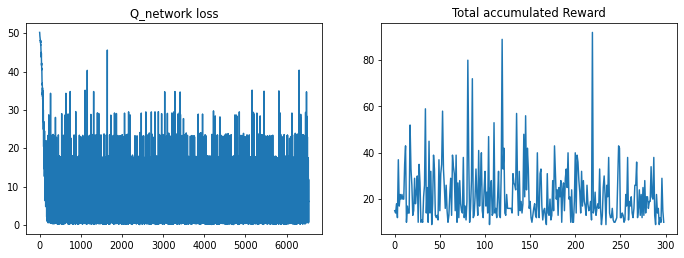

.........................................................................................................
Evaluation Score:  9.58095238095238
Total_timesteps: 6635 | Epsilon: 0.9359999999999999
Total_timesteps: 6658 | Epsilon: 0.9359999999999999
Total_timesteps: 6672 | Epsilon: 0.9359999999999999
Total_timesteps: 6682 | Epsilon: 0.9359999999999999
Total_timesteps: 6707 | Epsilon: 0.9359999999999999
Total_timesteps: 6719 | Epsilon: 0.9359999999999999
Total_timesteps: 6729 | Epsilon: 0.9359999999999999
Total_timesteps: 6766 | Epsilon: 0.9359999999999999
Total_timesteps: 6779 | Epsilon: 0.9359999999999999
Total_timesteps: 6792 | Epsilon: 0.9359999999999999
Total_timesteps: 6832 | Epsilon: 0.9359999999999999
Total_timesteps: 6860 | Epsilon: 0.9359999999999999
Total_timesteps: 6885 | Epsilon: 0.9359999999999999
Total_timesteps: 6918 | Epsilon: 0.9359999999999999
Total_timesteps: 6932 | Epsilon: 0.9359999999999999
Total_timesteps: 6943 | Epsilon: 0.9359999999999999
Total_timesteps: 6956 | Ep

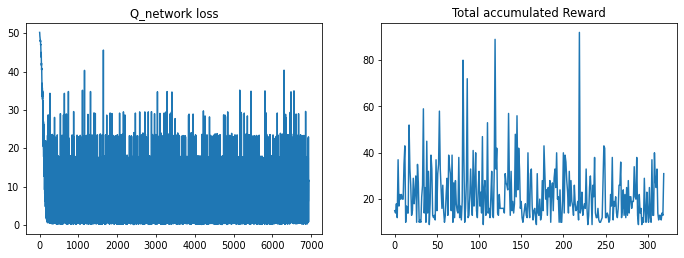

.........................................................................................................
Evaluation Score:  9.60952380952381
Total_timesteps: 7038 | Epsilon: 0.9319999999999999
Total_timesteps: 7063 | Epsilon: 0.9319999999999999
Total_timesteps: 7096 | Epsilon: 0.9319999999999999
Total_timesteps: 7107 | Epsilon: 0.9319999999999999
Total_timesteps: 7120 | Epsilon: 0.9319999999999999
Total_timesteps: 7135 | Epsilon: 0.9319999999999999
Total_timesteps: 7181 | Epsilon: 0.9319999999999999
Total_timesteps: 7205 | Epsilon: 0.9319999999999999
Total_timesteps: 7229 | Epsilon: 0.9319999999999999
Total_timesteps: 7242 | Epsilon: 0.9319999999999999
Total_timesteps: 7294 | Epsilon: 0.9319999999999999
Total_timesteps: 7305 | Epsilon: 0.9319999999999999
Total_timesteps: 7348 | Epsilon: 0.9319999999999999
Total_timesteps: 7367 | Epsilon: 0.9319999999999999
Total_timesteps: 7382 | Epsilon: 0.9319999999999999
Total_timesteps: 7397 | Epsilon: 0.9319999999999999
Total_timesteps: 7406 | Ep

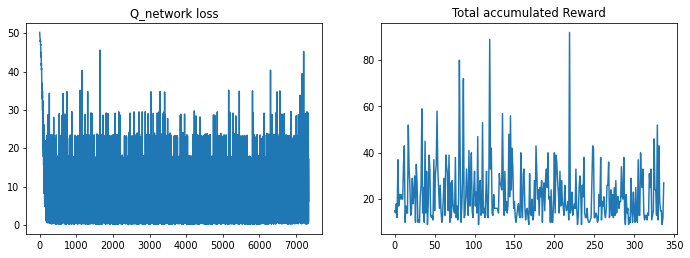

......................................................................................................
Evaluation Score:  9.813725490196079
Total_timesteps: 7445 | Epsilon: 0.9279999999999999
Total_timesteps: 7497 | Epsilon: 0.9279999999999999
Total_timesteps: 7508 | Epsilon: 0.9279999999999999
Total_timesteps: 7523 | Epsilon: 0.9279999999999999
Total_timesteps: 7544 | Epsilon: 0.9279999999999999
Total_timesteps: 7568 | Epsilon: 0.9279999999999999
Total_timesteps: 7600 | Epsilon: 0.9279999999999999
Total_timesteps: 7616 | Epsilon: 0.9279999999999999
Total_timesteps: 7646 | Epsilon: 0.9279999999999999
Total_timesteps: 7664 | Epsilon: 0.9279999999999999
Total_timesteps: 7705 | Epsilon: 0.9279999999999999
Total_timesteps: 7735 | Epsilon: 0.9279999999999999
Total_timesteps: 7766 | Epsilon: 0.9279999999999999
Total_timesteps: 7786 | Epsilon: 0.9279999999999999
Total_timesteps: 7806 | Epsilon: 0.9279999999999999
Total_timesteps: 7831 | Epsilon: 0.9279999999999999


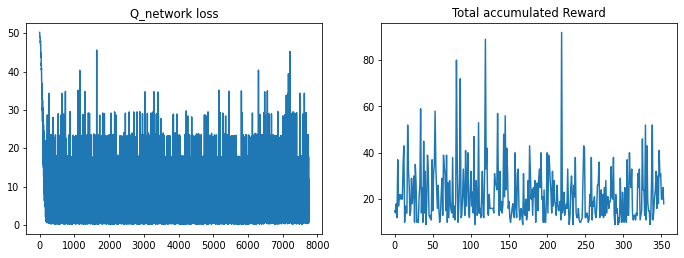

.........................................................................................................
Evaluation Score:  9.6
Total_timesteps: 7849 | Epsilon: 0.9239999999999999
Total_timesteps: 7867 | Epsilon: 0.9239999999999999
Total_timesteps: 7880 | Epsilon: 0.9239999999999999
Total_timesteps: 7895 | Epsilon: 0.9239999999999999
Total_timesteps: 7935 | Epsilon: 0.9239999999999999
Total_timesteps: 7962 | Epsilon: 0.9239999999999999
Total_timesteps: 7987 | Epsilon: 0.9239999999999999
Total_timesteps: 8029 | Epsilon: 0.9239999999999999
Total_timesteps: 8054 | Epsilon: 0.9239999999999999
Total_timesteps: 8075 | Epsilon: 0.9239999999999999
Total_timesteps: 8101 | Epsilon: 0.9239999999999999
Total_timesteps: 8115 | Epsilon: 0.9239999999999999
Total_timesteps: 8135 | Epsilon: 0.9239999999999999
Total_timesteps: 8158 | Epsilon: 0.9239999999999999
Total_timesteps: 8170 | Epsilon: 0.9239999999999999
Total_timesteps: 8179 | Epsilon: 0.9239999999999999
Total_timesteps: 8193 | Epsilon: 0.9239

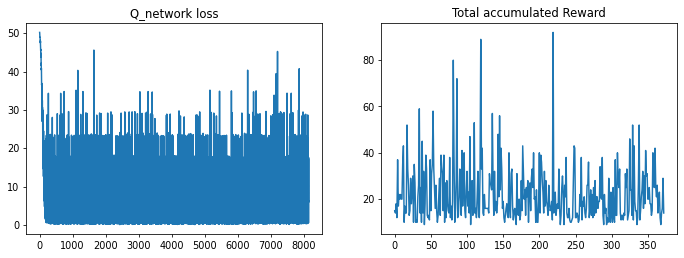

.........................................................................................................
Evaluation Score:  9.58095238095238
Total_timesteps: 8252 | Epsilon: 0.9199999999999999
Total_timesteps: 8263 | Epsilon: 0.9199999999999999
Total_timesteps: 8274 | Epsilon: 0.9199999999999999
Total_timesteps: 8292 | Epsilon: 0.9199999999999999
Total_timesteps: 8314 | Epsilon: 0.9199999999999999
Total_timesteps: 8334 | Epsilon: 0.9199999999999999
Total_timesteps: 8356 | Epsilon: 0.9199999999999999
Total_timesteps: 8371 | Epsilon: 0.9199999999999999
Total_timesteps: 8380 | Epsilon: 0.9199999999999999
Total_timesteps: 8407 | Epsilon: 0.9199999999999999
Total_timesteps: 8439 | Epsilon: 0.9199999999999999
Total_timesteps: 8471 | Epsilon: 0.9199999999999999
Total_timesteps: 8484 | Epsilon: 0.9199999999999999
Total_timesteps: 8503 | Epsilon: 0.9199999999999999
Total_timesteps: 8535 | Epsilon: 0.9199999999999999
Total_timesteps: 8561 | Epsilon: 0.9199999999999999
Total_timesteps: 8594 | Ep

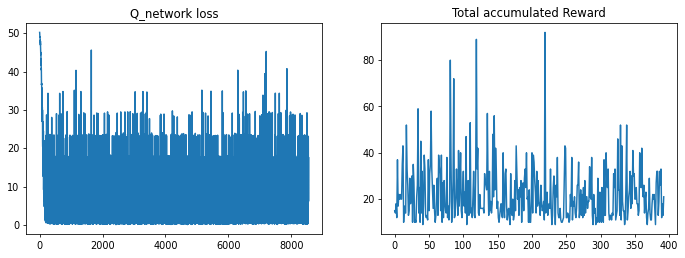

.........................................................................................................
Evaluation Score:  9.542857142857143
Total_timesteps: 8658 | Epsilon: 0.9159999999999999
Total_timesteps: 8682 | Epsilon: 0.9159999999999999
Total_timesteps: 8705 | Epsilon: 0.9159999999999999
Total_timesteps: 8718 | Epsilon: 0.9159999999999999
Total_timesteps: 8731 | Epsilon: 0.9159999999999999
Total_timesteps: 8759 | Epsilon: 0.9159999999999999
Total_timesteps: 8780 | Epsilon: 0.9159999999999999
Total_timesteps: 8803 | Epsilon: 0.9159999999999999
Total_timesteps: 8819 | Epsilon: 0.9159999999999999
Total_timesteps: 8834 | Epsilon: 0.9159999999999999
Total_timesteps: 8844 | Epsilon: 0.9159999999999999
Total_timesteps: 8855 | Epsilon: 0.9159999999999999
Total_timesteps: 8869 | Epsilon: 0.9159999999999999
Total_timesteps: 8899 | Epsilon: 0.9159999999999999
Total_timesteps: 8924 | Epsilon: 0.9159999999999999
Total_timesteps: 8942 | Epsilon: 0.9159999999999999
Total_timesteps: 8980 | E

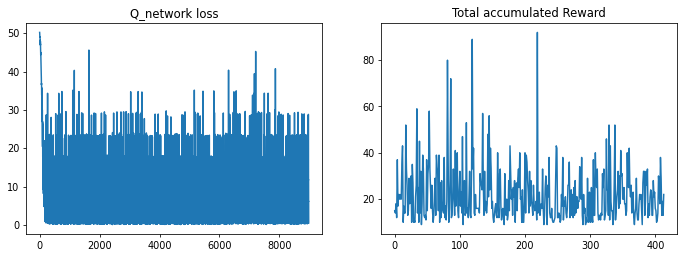

.........................................................................................................
Evaluation Score:  9.571428571428571
Total_timesteps: 9076 | Epsilon: 0.9119999999999999
Total_timesteps: 9086 | Epsilon: 0.9119999999999999
Total_timesteps: 9103 | Epsilon: 0.9119999999999999
Total_timesteps: 9114 | Epsilon: 0.9119999999999999
Total_timesteps: 9133 | Epsilon: 0.9119999999999999
Total_timesteps: 9151 | Epsilon: 0.9119999999999999
Total_timesteps: 9164 | Epsilon: 0.9119999999999999
Total_timesteps: 9177 | Epsilon: 0.9119999999999999
Total_timesteps: 9193 | Epsilon: 0.9119999999999999
Total_timesteps: 9244 | Epsilon: 0.9119999999999999
Total_timesteps: 9260 | Epsilon: 0.9119999999999999
Total_timesteps: 9275 | Epsilon: 0.9119999999999999
Total_timesteps: 9296 | Epsilon: 0.9119999999999999
Total_timesteps: 9312 | Epsilon: 0.9119999999999999
Total_timesteps: 9320 | Epsilon: 0.9119999999999999
Total_timesteps: 9346 | Epsilon: 0.9119999999999999
Total_timesteps: 9357 | E

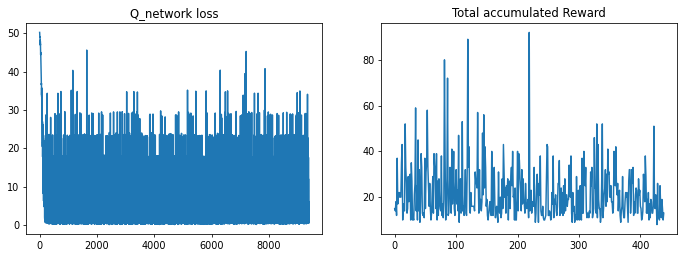

..........................................................................................................
Evaluation Score:  9.471698113207546
Total_timesteps: 9489 | Epsilon: 0.9079999999999999
Total_timesteps: 9529 | Epsilon: 0.9079999999999999
Total_timesteps: 9545 | Epsilon: 0.9079999999999999
Total_timesteps: 9562 | Epsilon: 0.9079999999999999
Total_timesteps: 9603 | Epsilon: 0.9079999999999999
Total_timesteps: 9614 | Epsilon: 0.9079999999999999
Total_timesteps: 9633 | Epsilon: 0.9079999999999999
Total_timesteps: 9665 | Epsilon: 0.9079999999999999
Total_timesteps: 9684 | Epsilon: 0.9079999999999999
Total_timesteps: 9696 | Epsilon: 0.9079999999999999
Total_timesteps: 9721 | Epsilon: 0.9079999999999999
Total_timesteps: 9793 | Epsilon: 0.9079999999999999
Total_timesteps: 9825 | Epsilon: 0.9079999999999999
Total_timesteps: 9845 | Epsilon: 0.9079999999999999
Total_timesteps: 9856 | Epsilon: 0.9079999999999999
Total_timesteps: 9874 | Epsilon: 0.9079999999999999
Total_timesteps: 9885 | 

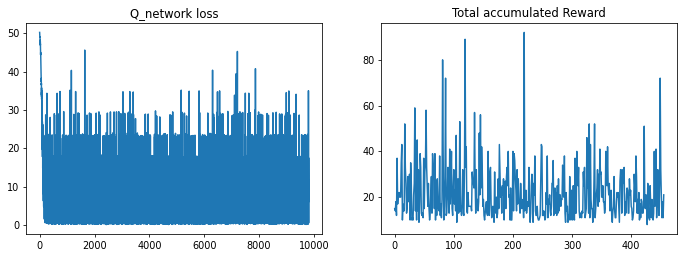

........................................................................................................
Evaluation Score:  9.625
Total_timesteps: 9906 | Epsilon: 0.9039999999999999
Total_timesteps: 9927 | Epsilon: 0.9039999999999999
Total_timesteps: 9939 | Epsilon: 0.9039999999999999
Total_timesteps: 9948 | Epsilon: 0.9039999999999999
Total_timesteps: 9962 | Epsilon: 0.9039999999999999
Total_timesteps: 9991 | Epsilon: 0.9039999999999999
Total_timesteps: 10080 | Epsilon: 0.9039999999999999
Total_timesteps: 10120 | Epsilon: 0.9039999999999999
Total_timesteps: 10154 | Epsilon: 0.9039999999999999
Total_timesteps: 10177 | Epsilon: 0.9039999999999999
Total_timesteps: 10201 | Epsilon: 0.9039999999999999
Total_timesteps: 10212 | Epsilon: 0.9039999999999999
Total_timesteps: 10243 | Epsilon: 0.9039999999999999
Total_timesteps: 10268 | Epsilon: 0.9039999999999999


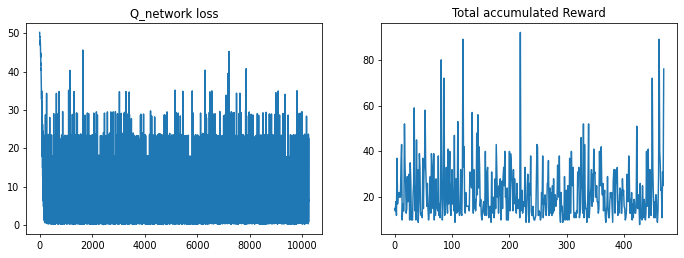

.........................................................................................................
Evaluation Score:  9.523809523809524
Total_timesteps: 10344 | Epsilon: 0.8999999999999999
Total_timesteps: 10360 | Epsilon: 0.8999999999999999
Total_timesteps: 10375 | Epsilon: 0.8999999999999999
Total_timesteps: 10403 | Epsilon: 0.8999999999999999
Total_timesteps: 10418 | Epsilon: 0.8999999999999999
Total_timesteps: 10434 | Epsilon: 0.8999999999999999
Total_timesteps: 10480 | Epsilon: 0.8999999999999999
Total_timesteps: 10507 | Epsilon: 0.8999999999999999
Total_timesteps: 10520 | Epsilon: 0.8999999999999999
Total_timesteps: 10543 | Epsilon: 0.8999999999999999
Total_timesteps: 10556 | Epsilon: 0.8999999999999999
Total_timesteps: 10569 | Epsilon: 0.8999999999999999
Total_timesteps: 10589 | Epsilon: 0.8999999999999999
Total_timesteps: 10599 | Epsilon: 0.8999999999999999
Total_timesteps: 10624 | Epsilon: 0.8999999999999999
Total_timesteps: 10654 | Epsilon: 0.8999999999999999
Total_tim

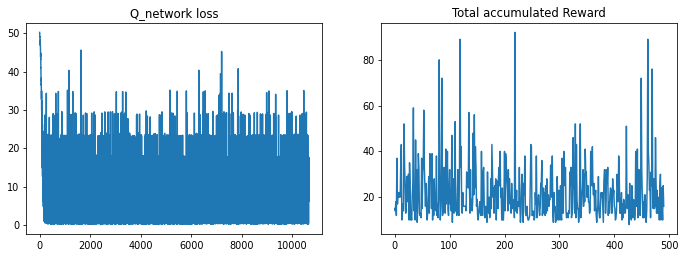

.........................................................................................................
Evaluation Score:  9.60952380952381
Total_timesteps: 10755 | Epsilon: 0.8959999999999999
Total_timesteps: 10781 | Epsilon: 0.8959999999999999
Total_timesteps: 10807 | Epsilon: 0.8959999999999999
Total_timesteps: 10823 | Epsilon: 0.8959999999999999
Total_timesteps: 10834 | Epsilon: 0.8959999999999999
Total_timesteps: 10853 | Epsilon: 0.8959999999999999
Total_timesteps: 10875 | Epsilon: 0.8959999999999999
Total_timesteps: 10888 | Epsilon: 0.8959999999999999
Total_timesteps: 10909 | Epsilon: 0.8959999999999999
Total_timesteps: 10945 | Epsilon: 0.8959999999999999
Total_timesteps: 10984 | Epsilon: 0.8959999999999999
Total_timesteps: 11010 | Epsilon: 0.8959999999999999
Total_timesteps: 11023 | Epsilon: 0.8959999999999999
Total_timesteps: 11039 | Epsilon: 0.8959999999999999
Total_timesteps: 11049 | Epsilon: 0.8959999999999999
Total_timesteps: 11066 | Epsilon: 0.8959999999999999
Total_time

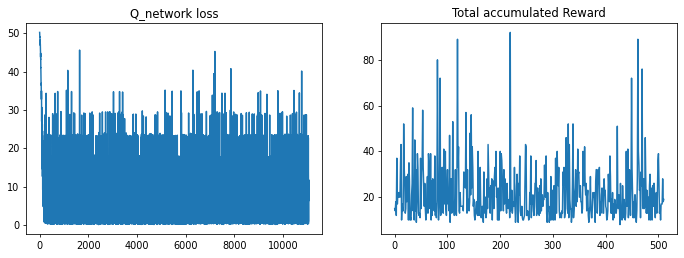

........................................................................................................
Evaluation Score:  9.673076923076923
Total_timesteps: 11165 | Epsilon: 0.8919999999999999
Total_timesteps: 11179 | Epsilon: 0.8919999999999999
Total_timesteps: 11195 | Epsilon: 0.8919999999999999
Total_timesteps: 11213 | Epsilon: 0.8919999999999999
Total_timesteps: 11234 | Epsilon: 0.8919999999999999
Total_timesteps: 11247 | Epsilon: 0.8919999999999999
Total_timesteps: 11266 | Epsilon: 0.8919999999999999
Total_timesteps: 11316 | Epsilon: 0.8919999999999999
Total_timesteps: 11326 | Epsilon: 0.8919999999999999
Total_timesteps: 11337 | Epsilon: 0.8919999999999999
Total_timesteps: 11359 | Epsilon: 0.8919999999999999
Total_timesteps: 11371 | Epsilon: 0.8919999999999999
Total_timesteps: 11387 | Epsilon: 0.8919999999999999
Total_timesteps: 11400 | Epsilon: 0.8919999999999999
Total_timesteps: 11413 | Epsilon: 0.8919999999999999
Total_timesteps: 11427 | Epsilon: 0.8919999999999999
Total_time

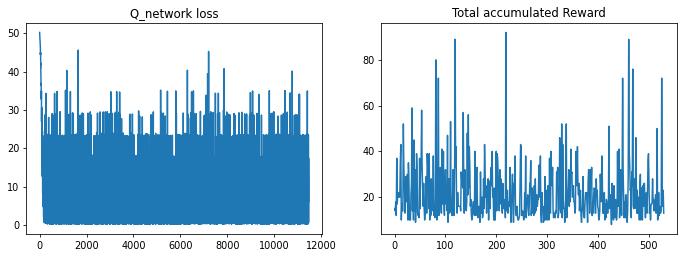

.........................................................................................................
Evaluation Score:  9.533333333333333
Total_timesteps: 11576 | Epsilon: 0.8879999999999999
Total_timesteps: 11600 | Epsilon: 0.8879999999999999
Total_timesteps: 11615 | Epsilon: 0.8879999999999999
Total_timesteps: 11638 | Epsilon: 0.8879999999999999
Total_timesteps: 11658 | Epsilon: 0.8879999999999999
Total_timesteps: 11680 | Epsilon: 0.8879999999999999
Total_timesteps: 11692 | Epsilon: 0.8879999999999999
Total_timesteps: 11707 | Epsilon: 0.8879999999999999
Total_timesteps: 11718 | Epsilon: 0.8879999999999999
Total_timesteps: 11755 | Epsilon: 0.8879999999999999
Total_timesteps: 11770 | Epsilon: 0.8879999999999999
Total_timesteps: 11796 | Epsilon: 0.8879999999999999
Total_timesteps: 11826 | Epsilon: 0.8879999999999999
Total_timesteps: 11852 | Epsilon: 0.8879999999999999
Total_timesteps: 11862 | Epsilon: 0.8879999999999999
Total_timesteps: 11883 | Epsilon: 0.8879999999999999
Total_tim

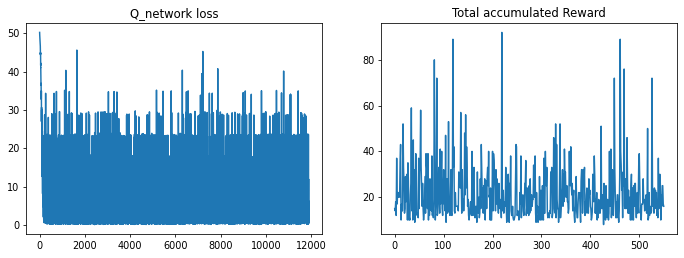

..........................................................................................................
Evaluation Score:  9.462264150943396
Total_timesteps: 11982 | Epsilon: 0.8839999999999999
Total_timesteps: 11996 | Epsilon: 0.8839999999999999
Total_timesteps: 12008 | Epsilon: 0.8839999999999999
Total_timesteps: 12019 | Epsilon: 0.8839999999999999
Total_timesteps: 12034 | Epsilon: 0.8839999999999999
Total_timesteps: 12049 | Epsilon: 0.8839999999999999
Total_timesteps: 12069 | Epsilon: 0.8839999999999999
Total_timesteps: 12103 | Epsilon: 0.8839999999999999
Total_timesteps: 12113 | Epsilon: 0.8839999999999999
Total_timesteps: 12140 | Epsilon: 0.8839999999999999
Total_timesteps: 12158 | Epsilon: 0.8839999999999999
Total_timesteps: 12188 | Epsilon: 0.8839999999999999
Total_timesteps: 12199 | Epsilon: 0.8839999999999999
Total_timesteps: 12221 | Epsilon: 0.8839999999999999
Total_timesteps: 12268 | Epsilon: 0.8839999999999999
Total_timesteps: 12343 | Epsilon: 0.8839999999999999
Total_ti

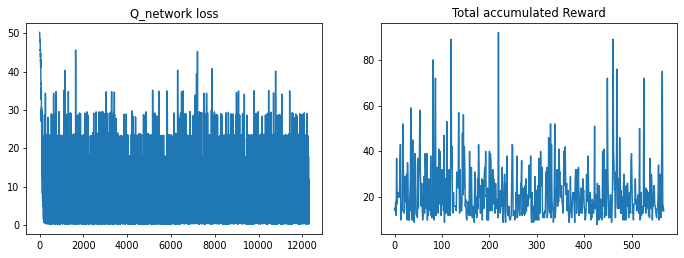

........................................................................................................
Evaluation Score:  9.64423076923077
Total_timesteps: 12387 | Epsilon: 0.8799999999999999
Total_timesteps: 12399 | Epsilon: 0.8799999999999999
Total_timesteps: 12421 | Epsilon: 0.8799999999999999
Total_timesteps: 12436 | Epsilon: 0.8799999999999999
Total_timesteps: 12450 | Epsilon: 0.8799999999999999
Total_timesteps: 12462 | Epsilon: 0.8799999999999999
Total_timesteps: 12475 | Epsilon: 0.8799999999999999
Total_timesteps: 12491 | Epsilon: 0.8799999999999999
Total_timesteps: 12503 | Epsilon: 0.8799999999999999
Total_timesteps: 12521 | Epsilon: 0.8799999999999999
Total_timesteps: 12550 | Epsilon: 0.8799999999999999
Total_timesteps: 12564 | Epsilon: 0.8799999999999999
Total_timesteps: 12594 | Epsilon: 0.8799999999999999
Total_timesteps: 12641 | Epsilon: 0.8799999999999999
Total_timesteps: 12660 | Epsilon: 0.8799999999999999
Total_timesteps: 12697 | Epsilon: 0.8799999999999999
Total_times

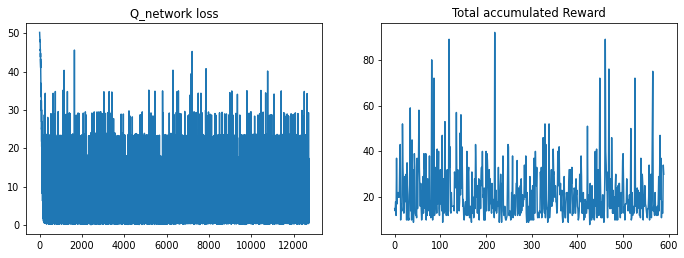

........................................................................................................
Evaluation Score:  9.625
Total_timesteps: 12816 | Epsilon: 0.8759999999999999
Total_timesteps: 12846 | Epsilon: 0.8759999999999999
Total_timesteps: 12861 | Epsilon: 0.8759999999999999
Total_timesteps: 12880 | Epsilon: 0.8759999999999999
Total_timesteps: 12891 | Epsilon: 0.8759999999999999
Total_timesteps: 12902 | Epsilon: 0.8759999999999999
Total_timesteps: 12922 | Epsilon: 0.8759999999999999
Total_timesteps: 12935 | Epsilon: 0.8759999999999999
Total_timesteps: 12950 | Epsilon: 0.8759999999999999
Total_timesteps: 12965 | Epsilon: 0.8759999999999999
Total_timesteps: 13016 | Epsilon: 0.8759999999999999
Total_timesteps: 13034 | Epsilon: 0.8759999999999999
Total_timesteps: 13069 | Epsilon: 0.8759999999999999
Total_timesteps: 13081 | Epsilon: 0.8759999999999999
Total_timesteps: 13133 | Epsilon: 0.8759999999999999
Total_timesteps: 13152 | Epsilon: 0.8759999999999999
Total_timesteps: 13189

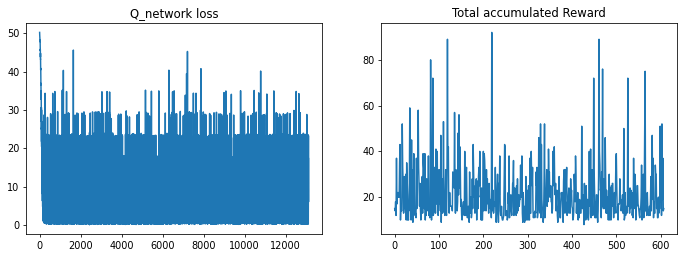

.......................................................................................................
Evaluation Score:  9.718446601941748
Total_timesteps: 13218 | Epsilon: 0.8719999999999999
Total_timesteps: 13240 | Epsilon: 0.8719999999999999
Total_timesteps: 13260 | Epsilon: 0.8719999999999999
Total_timesteps: 13282 | Epsilon: 0.8719999999999999
Total_timesteps: 13317 | Epsilon: 0.8719999999999999
Total_timesteps: 13330 | Epsilon: 0.8719999999999999
Total_timesteps: 13352 | Epsilon: 0.8719999999999999
Total_timesteps: 13368 | Epsilon: 0.8719999999999999
Total_timesteps: 13382 | Epsilon: 0.8719999999999999
Total_timesteps: 13403 | Epsilon: 0.8719999999999999
Total_timesteps: 13419 | Epsilon: 0.8719999999999999
Total_timesteps: 13434 | Epsilon: 0.8719999999999999
Total_timesteps: 13450 | Epsilon: 0.8719999999999999
Total_timesteps: 13476 | Epsilon: 0.8719999999999999
Total_timesteps: 13502 | Epsilon: 0.8719999999999999
Total_timesteps: 13521 | Epsilon: 0.8719999999999999
Total_times

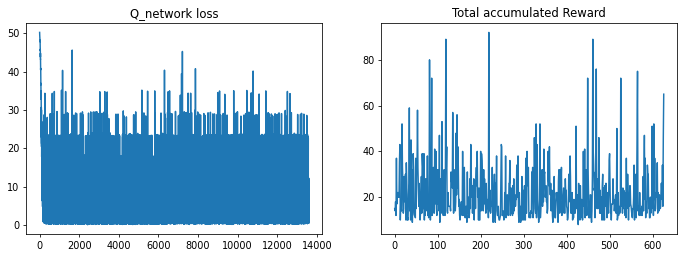

.........................................................................................................
Evaluation Score:  9.59047619047619
Total_timesteps: 13682 | Epsilon: 0.8679999999999999
Total_timesteps: 13694 | Epsilon: 0.8679999999999999
Total_timesteps: 13712 | Epsilon: 0.8679999999999999
Total_timesteps: 13759 | Epsilon: 0.8679999999999999
Total_timesteps: 13799 | Epsilon: 0.8679999999999999
Total_timesteps: 13822 | Epsilon: 0.8679999999999999
Total_timesteps: 13839 | Epsilon: 0.8679999999999999
Total_timesteps: 13865 | Epsilon: 0.8679999999999999
Total_timesteps: 13876 | Epsilon: 0.8679999999999999
Total_timesteps: 13892 | Epsilon: 0.8679999999999999
Total_timesteps: 13904 | Epsilon: 0.8679999999999999
Total_timesteps: 13918 | Epsilon: 0.8679999999999999
Total_timesteps: 13945 | Epsilon: 0.8679999999999999
Total_timesteps: 13971 | Epsilon: 0.8679999999999999
Total_timesteps: 13981 | Epsilon: 0.8679999999999999
Total_timesteps: 13996 | Epsilon: 0.8679999999999999
Total_time

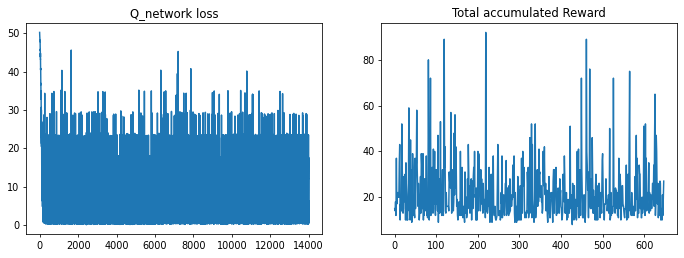

.........................................................................................................
Evaluation Score:  9.571428571428571
Total_timesteps: 14097 | Epsilon: 0.8639999999999999
Total_timesteps: 14117 | Epsilon: 0.8639999999999999
Total_timesteps: 14129 | Epsilon: 0.8639999999999999
Total_timesteps: 14168 | Epsilon: 0.8639999999999999
Total_timesteps: 14184 | Epsilon: 0.8639999999999999
Total_timesteps: 14197 | Epsilon: 0.8639999999999999
Total_timesteps: 14218 | Epsilon: 0.8639999999999999
Total_timesteps: 14234 | Epsilon: 0.8639999999999999
Total_timesteps: 14283 | Epsilon: 0.8639999999999999
Total_timesteps: 14315 | Epsilon: 0.8639999999999999
Total_timesteps: 14337 | Epsilon: 0.8639999999999999
Total_timesteps: 14355 | Epsilon: 0.8639999999999999
Total_timesteps: 14389 | Epsilon: 0.8639999999999999
Total_timesteps: 14409 | Epsilon: 0.8639999999999999
Total_timesteps: 14427 | Epsilon: 0.8639999999999999
Total_timesteps: 14450 | Epsilon: 0.8639999999999999
Total_tim

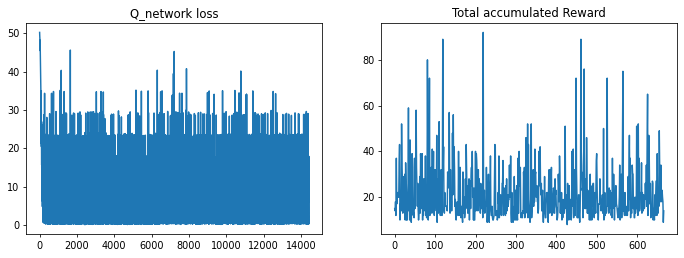

..........................................................................................................
Evaluation Score:  9.50943396226415
Total_timesteps: 14511 | Epsilon: 0.8599999999999999
Total_timesteps: 14534 | Epsilon: 0.8599999999999999
Total_timesteps: 14559 | Epsilon: 0.8599999999999999
Total_timesteps: 14580 | Epsilon: 0.8599999999999999
Total_timesteps: 14591 | Epsilon: 0.8599999999999999
Total_timesteps: 14603 | Epsilon: 0.8599999999999999
Total_timesteps: 14613 | Epsilon: 0.8599999999999999
Total_timesteps: 14655 | Epsilon: 0.8599999999999999
Total_timesteps: 14696 | Epsilon: 0.8599999999999999
Total_timesteps: 14717 | Epsilon: 0.8599999999999999
Total_timesteps: 14747 | Epsilon: 0.8599999999999999
Total_timesteps: 14774 | Epsilon: 0.8599999999999999
Total_timesteps: 14800 | Epsilon: 0.8599999999999999
Total_timesteps: 14853 | Epsilon: 0.8599999999999999
Total_timesteps: 14878 | Epsilon: 0.8599999999999999
Total_timesteps: 14895 | Epsilon: 0.8599999999999999


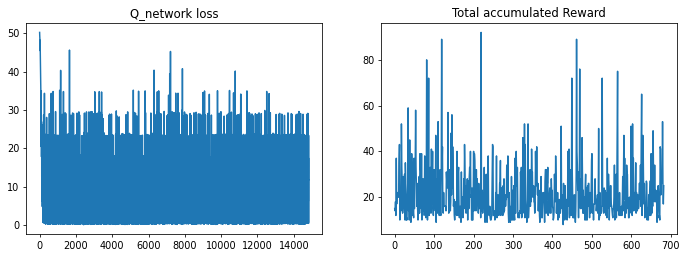

..........................................................................................................
Evaluation Score:  9.49056603773585
Total_timesteps: 14920 | Epsilon: 0.8559999999999999
Total_timesteps: 14938 | Epsilon: 0.8559999999999999
Total_timesteps: 14957 | Epsilon: 0.8559999999999999
Total_timesteps: 14988 | Epsilon: 0.8559999999999999
Total_timesteps: 15015 | Epsilon: 0.8559999999999999
Total_timesteps: 15083 | Epsilon: 0.8559999999999999
Total_timesteps: 15093 | Epsilon: 0.8559999999999999
Total_timesteps: 15105 | Epsilon: 0.8559999999999999
Total_timesteps: 15144 | Epsilon: 0.8559999999999999
Total_timesteps: 15163 | Epsilon: 0.8559999999999999
Total_timesteps: 15187 | Epsilon: 0.8559999999999999
Total_timesteps: 15201 | Epsilon: 0.8559999999999999
Total_timesteps: 15217 | Epsilon: 0.8559999999999999
Total_timesteps: 15248 | Epsilon: 0.8559999999999999
Total_timesteps: 15281 | Epsilon: 0.8559999999999999
Total_timesteps: 15301 | Epsilon: 0.8559999999999999
Total_tim

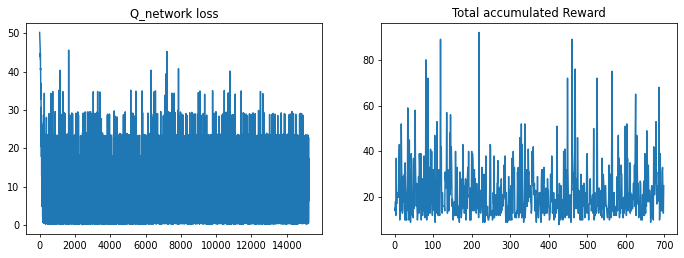

...........................................................................................................
Evaluation Score:  9.383177570093459
Total_timesteps: 15339 | Epsilon: 0.8519999999999999
Total_timesteps: 15364 | Epsilon: 0.8519999999999999
Total_timesteps: 15374 | Epsilon: 0.8519999999999999
Total_timesteps: 15388 | Epsilon: 0.8519999999999999
Total_timesteps: 15401 | Epsilon: 0.8519999999999999
Total_timesteps: 15439 | Epsilon: 0.8519999999999999
Total_timesteps: 15452 | Epsilon: 0.8519999999999999
Total_timesteps: 15536 | Epsilon: 0.8519999999999999
Total_timesteps: 15545 | Epsilon: 0.8519999999999999
Total_timesteps: 15555 | Epsilon: 0.8519999999999999
Total_timesteps: 15579 | Epsilon: 0.8519999999999999
Total_timesteps: 15596 | Epsilon: 0.8519999999999999
Total_timesteps: 15624 | Epsilon: 0.8519999999999999
Total_timesteps: 15642 | Epsilon: 0.8519999999999999
Total_timesteps: 15654 | Epsilon: 0.8519999999999999
Total_timesteps: 15669 | Epsilon: 0.8519999999999999
Total_t

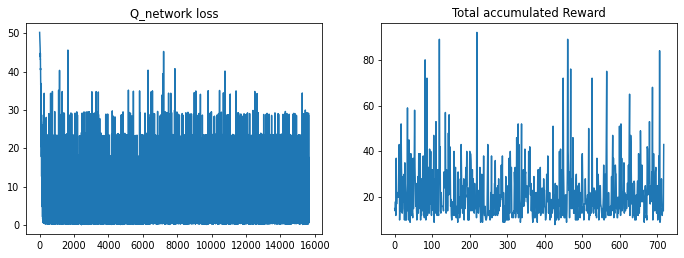

........................................................................................................
Evaluation Score:  9.663461538461538
Total_timesteps: 15741 | Epsilon: 0.8479999999999999
Total_timesteps: 15773 | Epsilon: 0.8479999999999999
Total_timesteps: 15788 | Epsilon: 0.8479999999999999
Total_timesteps: 15853 | Epsilon: 0.8479999999999999
Total_timesteps: 15872 | Epsilon: 0.8479999999999999
Total_timesteps: 15910 | Epsilon: 0.8479999999999999
Total_timesteps: 15923 | Epsilon: 0.8479999999999999
Total_timesteps: 15933 | Epsilon: 0.8479999999999999
Total_timesteps: 15947 | Epsilon: 0.8479999999999999
Total_timesteps: 15958 | Epsilon: 0.8479999999999999
Total_timesteps: 15990 | Epsilon: 0.8479999999999999
Total_timesteps: 15999 | Epsilon: 0.8479999999999999
Total_timesteps: 16010 | Epsilon: 0.8479999999999999
Total_timesteps: 16033 | Epsilon: 0.8479999999999999
Total_timesteps: 16047 | Epsilon: 0.8479999999999999
Total_timesteps: 16072 | Epsilon: 0.8479999999999999
Total_time

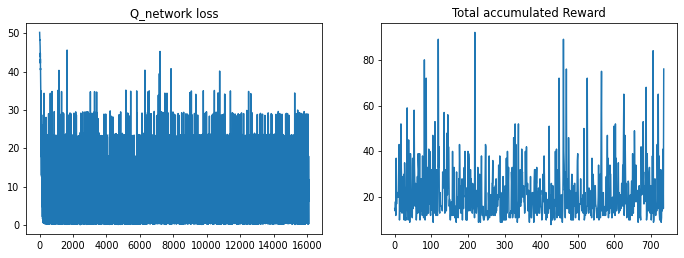

..........................................................................................................
Evaluation Score:  9.518867924528301
Total_timesteps: 16204 | Epsilon: 0.8439999999999999
Total_timesteps: 16222 | Epsilon: 0.8439999999999999
Total_timesteps: 16233 | Epsilon: 0.8439999999999999
Total_timesteps: 16252 | Epsilon: 0.8439999999999999
Total_timesteps: 16277 | Epsilon: 0.8439999999999999
Total_timesteps: 16290 | Epsilon: 0.8439999999999999
Total_timesteps: 16307 | Epsilon: 0.8439999999999999
Total_timesteps: 16322 | Epsilon: 0.8439999999999999
Total_timesteps: 16344 | Epsilon: 0.8439999999999999
Total_timesteps: 16361 | Epsilon: 0.8439999999999999
Total_timesteps: 16374 | Epsilon: 0.8439999999999999
Total_timesteps: 16391 | Epsilon: 0.8439999999999999
Total_timesteps: 16402 | Epsilon: 0.8439999999999999
Total_timesteps: 16438 | Epsilon: 0.8439999999999999
Total_timesteps: 16469 | Epsilon: 0.8439999999999999
Total_timesteps: 16499 | Epsilon: 0.8439999999999999


In [ ]:
total_scores = []
total_loss = []
median_accumulated_reward = []
total_evaluation_scores = []

prev_eval_score, prev_eval_marker = 0, 0
prev_tuning_score = 0

while np.sum(total_scores) < 1000000:   #Run episodes only till 1e6 timesteps

    print('Total_timesteps:', np.sum(total_scores), '| Epsilon:',agent.epsilon)

    state = env.reset()
    agent.lsm.reset_state()

    dead = False
    frames = 0

    while not dead:
        #env.render()
        frames += 1

        #1. Get action
        action = agent.get_action(state)

        #2. Perform action
        new_state, reward, dead, info = env.step(action)

        #3. Penalise if agent dies before episode ends
        if dead and frames!=env._max_episode_steps-1:
            reward = -1.

        #4. Remember 
        agent.remember((state, action, 10*reward, new_state, dead))

        #6. Update state for next frame
        state = new_state
        
        #7. Replay
        if len(agent.memory) > agent.training_threshold:
            total_loss.append(agent.replay())

        if dead:
            total_scores.append(frames)    

    #Hyperparameter updates
    if (np.sum(total_scores) > prev_tuning_score + 400) or len(total_scores)==1:
        prev_tuning_score = np.sum(total_scores)        
        
        agent.update_epsilon(diff=0.004)
        agent.update_target_network()
        
        #print('Hidden layer bias:',agent.lsm.readout_network.state_dict()['hidden_layer.bias'])

        plt.figure(figsize=(12,4), dpi=70)
        plt.subplot(1,2,1)
        plt.title('Q_network loss')
        plt.plot(total_loss)
        plt.subplot(1,2,2)
        plt.title('Total accumulated Reward')
        plt.plot(total_scores)
        plt.show()

        eval_scores, num_of_games = 0, 0
        
        while eval_scores < 1000:   #Evaluate for 1000 timesteps
            print('.',end='')

            state = env.reset()
            agent.lsm.reset_state()

            score = 0
            dead = False

            while not dead:
                #Get action
                action = agent.get_action(state, epsilon = 0.05) #Exploit
                #2. Perform action
                new_state, reward, dead, info = env.step(action)
                #Update state
                state = new_state

                #Accumulate score over this gameplay
                score += 1

                if dead:
                    eval_scores += score
                    num_of_games += 1
        print() 
        total_evaluation_scores.append(eval_scores/num_of_games)
        print('Evaluation Score: ', total_evaluation_scores[-1])


    '''
    
    if np.sum(total_scores) > prev_eval_score + 1000:
        prev_eval_score = np.sum(total_scores)

        median_accumulated_reward.append(np.median(total_scores[prev_eval_marker:]))
        print('Median Accumulated Reward in last 1000 timesteps:',median_accumulated_reward[-1])
        prev_eval_marker = len(total_scores)

        plt.figure(figsize=(12,4), dpi=70)
        plt.subplot(1,3,1)
        plt.title('Median accumulated Reward')
        plt.plot(median_accumulated_reward)
        plt.subplot(1,3,2)
        plt.title('Total accumulated Reward')
        plt.plot(total_scores)
        plt.subplot(1,3,3)
        plt.title('Evaluation scores')
        plt.plot(total_evaluation_scores)
        plt.show()
        '''
    
env.close()